In [23]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

import numpy as np
from nltk.data import load
import sklearn
from sklearn import svm as SVM
from sklearn.model_selection import GridSearchCV
import nltk
import matplotlib.pyplot as plt
import helper
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('tagsets')
nltk.download('punkt')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/movieminer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /home/movieminer/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /home/movieminer/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package punkt to /home/movieminer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
data_path = 'A4data_2324_pan2020/'

def load_data():
    train_dataset = pd.read_csv(data_path + 'pan2324_train_data.csv')
    test_dataset = pd.read_csv(data_path + 'pan2324_test_data.csv')
    dev_dataset = pd.read_csv(data_path + 'pan2324_dev_data.csv')
    return train_dataset, test_dataset, dev_dataset

In [25]:
train_dataset, test_dataset, dev_dataset = load_data()

In [26]:
tagdict = load('help/tagsets/upenn_tagset.pickle')
function_words = helper.function_words

def feature_extraction(dataset):
    text = dataset['text']
    authors = dataset['author']
    features = {}

    # Character based features
    features['CF'] = pd.DataFrame()
    features['LETTERS'] = pd.DataFrame()
    features['CHARS'] = pd.DataFrame()

    features['CF']['char_count'] = text.apply(len)
    uppercase_count = text.apply(lambda x: sum([1 for char in x if char.isupper()]))
    features['CF']['uppercase_frequency'] = uppercase_count / features['CF']['char_count']
    digit_count = text.apply(lambda x: sum([1 for char in x if char.isdigit()]))
    features['CF']['digit_frequency'] = digit_count / features['CF']['char_count']
    features['CF']['whitespace_frequency'] = text.apply(lambda x: sum([1 for char in x if char == ' '])) / features['CF']['char_count']
    features['CF']['alphabet_count'] = text.apply(lambda x: sum([1 for letter in x.lower() if letter.isalpha()]))

    for letter in 'abcdefghijklmnopqrstuvwxyz':
        features['LETTERS'][letter + '_frequency'] = text.apply(lambda x: x.lower().count(letter)) / features['CF']['char_count']
        
    for special_character in ["~" , "@", "#", "$", "%", "^", "&", "*", "-", "_", "=" ,"+", ">", "<", "[", "]", "{", "}", "/", "\\", "|"]:
        features['CHARS'][special_character + '_frequency'] = text.apply(lambda x: x.count(special_character)) / features['CF']['char_count']

    # Word based features
    features['WF'] = pd.DataFrame()

    features['WF']['word_count'] = text.apply(lambda x: len(x.split()))
    features['WF']['avg_word_length'] = text.apply(lambda x: sum([len(word) for word in x.split()]) / len(x.split()))
    features['WF']['avg_sentence_length'] = text.apply(lambda x: sum([len(sentence) for sentence in x.split('.')]) / len(x.split('.')))
    features['WF']['avg_sentence_word_count'] = features['WF']['avg_sentence_length'] / features['WF']['avg_word_length']
    unique_words = text.apply(lambda x: len(set(x.split())))
    features['WF']['unique_words_frequency'] = unique_words / features['WF']['word_count']

    # Syntactic features
    features['PUNC'] = pd.DataFrame()

    punctuation_count = text.apply(lambda x: sum([1 for char in x if char in ['.', ',', ';', ':', '!', '?', "\'", "\""]]))
    features['PUNC']['punctuation_frequency'] = punctuation_count / features['CF']['char_count']
    
    new_columns = {}
    for function_word in function_words:
        new_columns[function_word + '_frequency'] = text.apply(lambda x: x.lower().count(function_word))

    features['FUNC'] = pd.DataFrame(new_columns)

    # Structural features
    features['STRUCTF'] = pd.DataFrame()

    features['STRUCTF']['sentence_count'] = text.apply(lambda x: len(x.split('.')))
    features['STRUCTF']['repeated_punctuation_frequency'] = text.apply(lambda x: sum([1 for i in range(len(x)) if x[i] in ['.', ',', ';', ':', '!', '?', "\'", "\""] and x[i] == x[i-1]])) / punctuation_count

    # POS features
    features['POS'] = pd.DataFrame()

    pos = text.apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))
    posfreq = pos.apply(lambda x: dict(nltk.FreqDist([tag for (word, tag) in x])))
    tags = list(tagdict)
    for i,tag in enumerate(tags):
        features['POS'][f'pos_{tag}'] = posfreq.apply(lambda x: x.get(tag, 0))

    # total_pos_tags = features['POS'].sum(axis=1)
    # for tag in tags:
    #     if tag.isalpha():
    #       features['POS'][f'pos_{tag}_frequency'] = features['POS'][f'pos_{tag}'] / total_pos_tags

    return features, authors

In [92]:
def dict_to_df(dictionary):
    df = pd.DataFrame()
    for key in dictionary.keys():
        df = pd.concat([df, dictionary[key]], axis=1)
    return df

def to_scalar(train, dev, test):
    df_train = dict_to_df(train).values
    df_dev = dict_to_df(dev).values
    df_test = dict_to_df(test).values

    scaler = StandardScaler()

    train_scaled = scaler.fit_transform(df_train)
    dev_scaled = scaler.transform(df_dev)
    test_scaled = scaler.transform(df_test)

    return train_scaled, dev_scaled, test_scaled

In [54]:
def train_model(X_train, y_train, X_dev, y_dev):
  clf = SVM.SVC()

  clf.fit(X_train, y_train)

  params = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf'], 'gamma': [0.01, 0.1, 1, 'scale', 'auto']}
  grid_search = GridSearchCV(clf, params, cv=5)
  grid_search.fit(X_dev, y_dev)
  
  best_clf = grid_search.best_estimator_
  best_score = grid_search.best_score_
  
  print(f'Best score: {best_score} with C={best_clf.C} and kernel={best_clf.kernel} and gamma={best_clf.gamma}')
  
  return best_clf, best_score

In [49]:
def save_features(features, authors, filename):
    features = dict_to_df(features)
    features['author'] = authors
    features.to_csv(f"features/{filename}", index=False)

In [93]:
X_train, y_train = feature_extraction(train_dataset)
X_dev, y_dev  = feature_extraction(dev_dataset)
X_test, y_test = feature_extraction(test_dataset)

save_features(X_train, y_train, 'train_features.csv')
save_features(X_dev, y_dev, 'dev_features.csv')
save_features(X_test, y_test, 'test_features.csv')

X_train_scalar, X_dev_scalar, X_test_scalar = to_scalar(X_train, X_dev, X_test)

KeyboardInterrupt: 

In [55]:
model, accuracy = train_model(X_train_scalar, y_train, X_dev_scalar, y_dev)
print(accuracy)

Best score: 0.6945035460992908 with C=0.1 and kernel=linear and gamma=0.01
0.6945035460992908


In [94]:
print(X_train_scalar.shape)
print(dict_to_df(X_train).shape)
print(dict_to_df(X_train))


(2853, 255)
(2853, 255)
      char_count  uppercase_frequency  digit_frequency  whitespace_frequency  \
0           3003             0.035298         0.000666              0.164169   
1           3077             0.020799         0.000000              0.190445   
2           3010             0.024252         0.000000              0.183721   
3           3080             0.018506         0.000000              0.173052   
4           3061             0.033322         0.000327              0.176740   
...          ...                  ...              ...                   ...   
2848        3084             0.037289         0.000000              0.178340   
2849        3064             0.040796         0.000000              0.167102   
2850        3083             0.028219         0.000649              0.181317   
2851        3042             0.024326         0.000000              0.178830   
2852        3001             0.022992         0.000000              0.184272   

      alphabet_

In [72]:
def ablation_analysis(X_train, y_train, X_dev, y_dev, X_features):
  scores = []
  f = []

  scores.append(model.score(X_train, y_train))
  f.append("None")

  for i,feature in enumerate(X_features.keys()):
    X_train_ablated = np.delete(X_train, i, 1)
    # X_dev_ablated = np.delete(X_dev, i, 0)

    model.fit(X_train_ablated, y_train)
    scores.append(model.score(X_train_ablated, y_train))
    f.append(feature)

  return f, scores

In [73]:
feature_names, scores = ablation_analysis(X_train_scalar, y_train, X_dev_scalar, y_dev, X_train)
print(feature_names)
print(scores)


['None', 'CF', 'LETTERS', 'CHARS', 'WF', 'PUNC', 'FUNC', 'STRUCTF', 'POS']
[0.6698212407991588, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


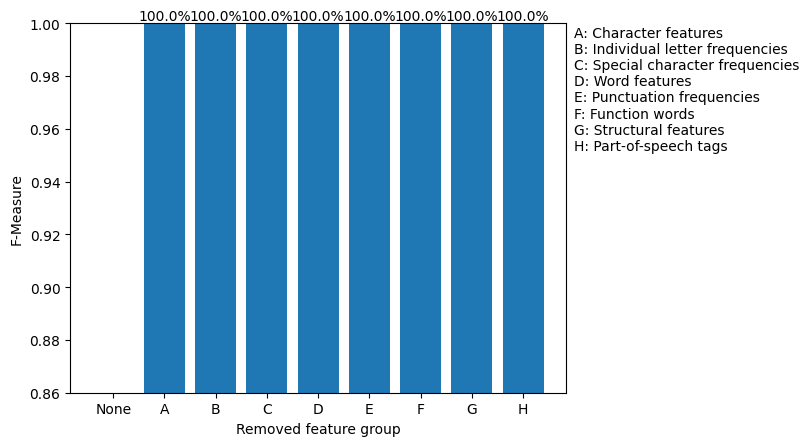

In [74]:
legend = ['A: Character features',
          'B: Individual letter frequencies', 
          'C: Special character frequencies',
          'D: Word features',
          'E: Punctuation frequencies',
          'F: Function words',
          'G: Structural features',
          'H: Part-of-speech tags']
legend = '\n'.join(legend)

fig, ax = plt.subplots()
bar_container = ax.bar(['None','A','B','C','D','E','F','G', 'H'], scores)
ax.set_ylim([0.86, 1])
ax.set_ylabel('F-Measure')
ax.set_xlabel('Removed feature group')
ax.bar_label(bar_container, fmt=lambda x: f'{x * 100:.1f}%')
plt.text(9,0.999, legend, va="top")

plt.show()

In [35]:

def test_accuracy(X_test, y_test, model):
  X_test_df = to_scalar(X_test)
  return model.score(X_test_df, y_test)

print(test_accuracy(X_test, y_test, model))

TypeError: to_scalar() missing 1 required positional argument: 'dev'